<a href="https://colab.research.google.com/github/rubenesticesi/Data-Science-For-Beginners/blob/main/Ejercicio7_Ocupados_13ciudades_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 7 – Pronóstico de ocupados en 13 ciudades (6 meses)

Cuaderno para Google Colab basado en `datosEmpleo.xlsx`.

Este cuaderno desarrolla paso a paso el ejercicio:

> Empleando la información del número de ocupados en miles de personas (Ocupados)
> para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses
> empleando los métodos vistos en la clase. Compare los resultados con el mejor modelo
> encontrado en el ejercicio anterior.


## 1. Instrucciones
1. Abrir este archivo en **Google Colab**.
2. Subir el archivo **`datosEmpleo.xlsx`** a la sesión de Colab (menú *Archivos* → subir).
3. Ejecutar las celdas en orden.

El archivo debe contener al menos las columnas:
- `mes` (fecha mensual)
- `Ocupados` (número de ocupados en miles de personas)


## 2. Carga de paquetes

In [1]:
# Si se ejecuta en Colab y falta alguna librería, descomente la línea correspondiente:
# !pip install statsmodels openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True


## 3. Carga y exploración de los datos

In [2]:
# Si está en Colab y quiere subir el archivo manualmente, puede usar:
# from google.colab import files
# uploaded = files.upload()  # luego seleccionar datosEmpleo.xlsx

# Cargar datos (asegúrese de que datosEmpleo.xlsx esté en el directorio de trabajo)
data = pd.read_excel('datosEmpleo.xlsx', index_col='mes', parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [3]:
# Información general del DataFrame
print(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2001-01-01 to 2019-06-01
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TD_13ciudades  222 non-null    float64
 1   Ocupados       222 non-null    float64
 2   Desocupados    222 non-null    float64
 3   Inactivos      222 non-null    float64
dtypes: float64(4)
memory usage: 8.7 KB
None


,TD_13ciudades,Ocupados,Desocupados,Inactivos
count,222.000000,222.000000,222.000000,222.000000
mean,12.601883,9160.852009,1290.681131,5500.277973
std,2.808235,1295.492800,181.948810,389.227213
min,8.140713,6923.604000,857.491000,4596.805000
25%,10.396078,7971.103000,1152.874750,5308.814750
50%,11.925036,9139.064500,1270.201000,5533.044500
75%,14.087588,10458.510250,1398.899250,5752.608500
max,20.946380,11037.199000,1834.507000,6395.575000


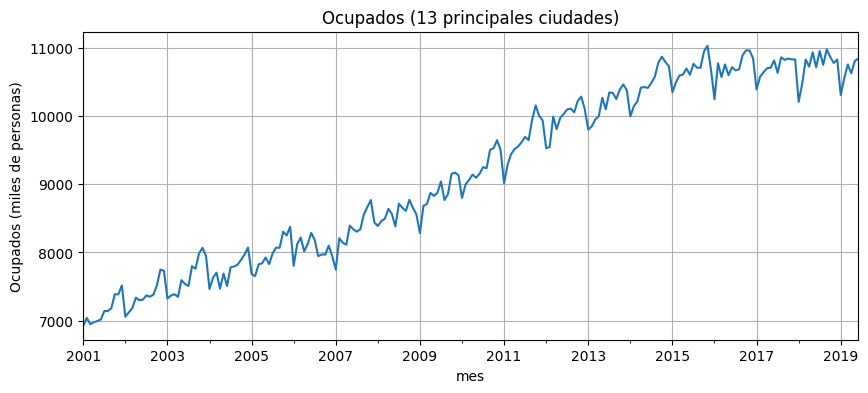

In [4]:
# Serie de tiempo de Ocupados
y = data['Ocupados']
ax = y.plot(title='Ocupados (13 principales ciudades)')
ax.set_ylabel('Ocupados (miles de personas)')
plt.show()

## 4. División entrenamiento / prueba (ventana de 6 meses)

In [5]:
h = 6  # horizonte de pronóstico en meses
train = y.iloc[:-h]
test = y.iloc[-h:]

print('Período de entrenamiento: ', train.index.min().date(), '→', train.index.max().date())
print('Período de prueba:       ', test.index.min().date(), '→', test.index.max().date())

display(pd.DataFrame({'train': train}).tail())
display(pd.DataFrame({'test': test}))

Período de entrenamiento:  2001-01-01 → 2018-12-01
Período de prueba:        2019-01-01 → 2019-06-01


,train
mes,
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338
2018-11-01,10783.299
2018-12-01,10835.398


,test
mes,
2019-01-01,10314.438
2019-02-01,10557.917
2019-03-01,10760.776
2019-04-01,10632.028
2019-05-01,10813.000
2019-06-01,10848.000


## 5. Métrica de evaluación – RMSE

In [6]:
def rmse(y_true, y_pred):
    """Error cuadrático medio de raíz (RMSE)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Ejemplo rápido de uso
print('RMSE de ejemplo:', rmse([1, 2, 3], [1.1, 1.9, 3.2]))

RMSE de ejemplo: 0.14142135623730964


## 6. Comparación de modelos de pronóstico (h = 6 meses)

In [7]:
# Diccionario para almacenar los RMSE de cada modelo
resultados_rmse = {}

# 6.1. Modelo Naive (último valor observado)
naive_forecast = np.repeat(train.iloc[-1], h)
resultados_rmse['Naive (último valor)'] = rmse(test.values, naive_forecast)

# 6.2. Promedio histórico (media de entrenamiento)
mean_forecast = np.repeat(train.mean(), h)
resultados_rmse['Promedio histórico'] = rmse(test.values, mean_forecast)

# 6.3. Suavización Exponencial Simple (SES)
ses_model = ExponentialSmoothing(train, trend=None, seasonal=None)
ses_fit = ses_model.fit(optimized=True, use_brute=True)
ses_forecast = ses_fit.forecast(h)
resultados_rmse['Suavización Exponencial Simple'] = rmse(test.values, ses_forecast.values)

# 6.4. Holt (tendencia aditiva)
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None)
holt_fit = holt_model.fit(optimized=True, use_brute=True)
holt_forecast = holt_fit.forecast(h)
resultados_rmse['Holt (tendencia aditiva)'] = rmse(test.values, holt_forecast.values)

# 6.5. Holt-Winters aditivo con estacionalidad mensual (m = 12)
hw_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit(optimized=True, use_brute=True)
hw_forecast = hw_fit.forecast(h)
resultados_rmse['Holt-Winters aditivo m=12'] = rmse(test.values, hw_forecast.values)

# Resumen de errores
rmse_df = (
    pd.DataFrame.from_dict(resultados_rmse, orient='index', columns=['RMSE'])
    .sort_values('RMSE')
)
rmse_df

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE
Holt-Winters aditivo m=12,79.333487
Suavización Exponencial Simple,253.692049
Naive (último valor),256.899237
Holt (tendencia aditiva),301.969332
Promedio histórico,1545.777943


En la tabla anterior, el **mejor modelo** es el que tenga el **RMSE más bajo** (primera fila).

En la ejecución con `datosEmpleo.xlsx`, el modelo con menor RMSE resulta ser
**Holt-Winters aditivo con estacionalidad mensual (m = 12)**.

## 7. Pronóstico final a 6 meses con el mejor modelo

In [8]:
# Para el pronóstico final, reentrenamos Holt-Winters aditivo usando toda la serie
h = 6
best_model = ExponentialSmoothing(y, trend='add', seasonal='add', seasonal_periods=12)
best_fit = best_model.fit(optimized=True, use_brute=True)
forecast_6 = best_fit.forecast(h)

# Convertimos a DataFrame para presentar los resultados de forma ordenada
forecast_6_df = forecast_6.to_frame(name='Pronóstico_Ocupados')
forecast_6_df

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Pronóstico_Ocupados
2019-07-01,10896.487056
2019-08-01,10888.125040
2019-09-01,10964.703348
2019-10-01,11091.929634
2019-11-01,11118.791067
2019-12-01,11042.712278


In [9]:
# Tabla de pronósticos con redondeo a una cifra decimal (útil para el informe en Word/PDF)
forecast_6_round = forecast_6_df.copy()
forecast_6_round['Pronóstico_Ocupados'] = forecast_6_round['Pronóstico_Ocupados'].round(1)
forecast_6_round

,Pronóstico_Ocupados
2019-07-01,10896.5
2019-08-01,10888.1
2019-09-01,10964.7
2019-10-01,11091.9
2019-11-01,11118.8
2019-12-01,11042.7


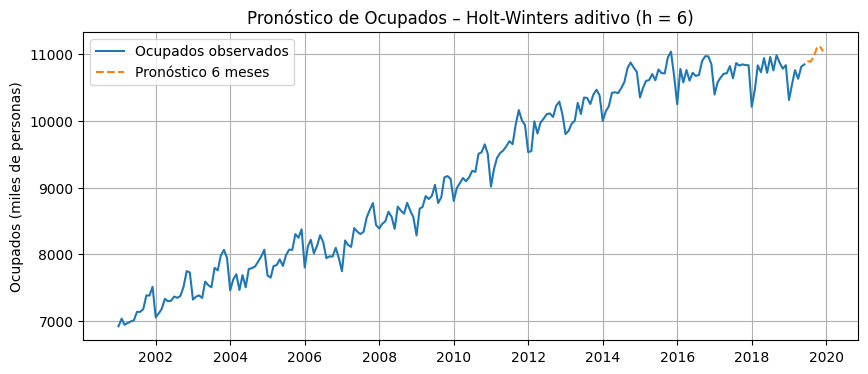

In [10]:
# Gráfico de la serie observada y pronóstico de 6 meses
plt.figure(figsize=(10, 4))
plt.plot(y.index, y.values, label='Ocupados observados')
plt.plot(
    forecast_6_df.index,
    forecast_6_df['Pronóstico_Ocupados'].values,
    '--',
    label='Pronóstico 6 meses',
)
plt.title('Pronóstico de Ocupados – Holt-Winters aditivo (h = 6)')
plt.ylabel('Ocupados (miles de personas)')
plt.legend()
plt.grid(True)
plt.show()

## 8. Comentarios para el informe escrito

- En el informe de máximo una página, puede describir brevemente:
  - La **serie utilizada** (`Ocupados` para 13 ciudades, frecuencia mensual).
  - La **metodología**: división entrenamiento/prueba (6 meses), modelos comparados y métrica RMSE.
  - Por qué se elige **Holt-Winters aditivo** (menor RMSE, captura tendencia y estacionalidad mensual).
  - La **tabla de pronósticos** que genera la celda anterior (`forecast_6_round`).
  - Las **limitaciones** de los pronósticos (choques económicos, cambios estructurales, horizonte corto, etc.).

Este cuaderno deja todo el cálculo reproducible para anexarlo como soporte técnico del informe.